In [2]:
# Get traces from mika's factorized 2-color datasets
import matplotlib.pyplot as plt
plt.style.use('npg')
import numpy as np
import h5py
import nibabel as nib
from scipy.signal import decimate,detrend
from fish.util.fileio import read_image
from fish.util.plot import proj_fuse
from scipy.io import loadmat

In [128]:
def stackline(x_axis, array, axis, scale, **kwargs):
    for ind, val in enumerate(array):
        axis.plot(x_axis, val - ind * scale, **kwargs)
    axis.set_xlim(x_axis.min(), x_axis.max())

def load_muy_mat(fname, head_name='data'):
    from h5py import File 
    from numpy import squeeze
    data = {}
    with File(fname) as f: 
        for k in f[head_name].keys():
            data[k] = squeeze(f[head_name][k][:])
    return data

def my_proj(data, fun, aspect):
    from skimage.transform import resize
    from numpy import zeros, array
    # project over z and y
    old_dims = array(data.shape)
    new_dims = array(aspect) * old_dims
    proj_axes = [0,1]    
    projs = []
    for axis, dim in enumerate(new_dims[:2]):
        indexer = list(range(len(new_dims)))
        indexer.pop(axis)
        projs.append(resize(fun(data, axis), new_dims[indexer], mode='constant', preserve_range=True))
    
    output = zeros([new_dims[0] + new_dims[1], new_dims[2]])
    output[:new_dims[0]] = projs[1]
    output[new_dims[0]:] = projs[0]
    
    return output

def get_roi_mean(fn, masks):
    from fish.util.fileio import read_image
    data = read_image(fn)
    data_ = {}
    data_['g'] = data[:,:data.shape[1]//2]
    data_['n'] = data[:,data.shape[1]//2:]
    masked_means = {k: np.array([data_[k][mask].mean() for mask in v]) for k, v in masks.items()}
    return masked_means

In [131]:
potential_paths = ['/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/',
                   '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170228/fish3/20170228_3_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_165730/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_2_gfaprgeco_hucgc_6dpf_wholebrain_20170221_220811/',
                  '/nrs/ahrens/Yu/newfromdm11/glia_neuron_imaging/20170221/fish5/20170221_5_3_gfaprgeco_hucgc_6dpf_wholebrain_20170221_223941/']

import sys
import json
import pathlib as pl
from os.path import sep
from glob import glob
from fish.image.vol import get_metadata
dirs = {}
dirs['base'] = potential_paths[0]
anat_ref = read_image(glob(dirs['base'] + '*anat_reference*.tif')[0])
exp_name = dirs['base'].split(sep)[-2]
dirs['ephys'] = dirs['base'] + 'ephys/'
dirs['raw'] = dirs['base'] + 'raw/'
dirs['dff'] = '/groups/ahrens/ahrenslab/davis/tmp/' + exp_name + '/projections/dff/'
dirs['output'] = '/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/'

dz = get_metadata(dirs['raw'] + '/ch0.xml')['z_step']
um_per_pixel = .40625
dx,dy = (metadata['spatial_downsampling'] * um_per_pixel,) * 2
from functools import reduce
from math import gcd
aspect = (10 * np.array([dz, dy, dx])).astype('int')
aspect = aspect // reduce(gcd, aspect)

with open(dirs['dff'] + 'metadata.json', 'r') as f:
    metadata = json.load(f)
dff_lims = metadata['dff_lims']
from fish.image.vol import get_stack_freq
fs_im = get_stack_freq(dirs['raw'])[0]

fnames = sorted(glob(dirs['dff'] + '*.tif'))

print(len(fnames))

7200


In [5]:
epdat = load_muy_mat(dirs['ephys'] + 'data.mat')
epdat_raw = load_muy_mat(dirs['ephys'] + 'rawdata.mat', head_name='rawdata')
swims = epdat['fltCh1'] + epdat['fltCh2']
cam = np.where(np.diff(epdat['frame']))[0][:len(fnames)]
fs_ep = 6000

In [6]:
%%time 

from skimage.transform import downscale_local_mean
from dipy.align.imaffine import transform_centers_of_mass, MutualInformationMetric, AffineRegistration
from dipy.align.transforms import TranslationTransform3D,RigidTransform3D,AffineTransform3D
# make dimension order [z y x]
# this image is 0-padded with 8 z planes, 4 top and 4 bottom, so remove those
ds_mika = 2
shave = slice(4,-4)
template_mika = nib.load('/groups/ahrens/ahrenslab/mika/yu/data/twoc/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/ana/image_reference_aligned0.nii.gz').get_data()
static = template_mika.T[shave]

moving = downscale_local_mean(anat_ref, (1,ds_mika,ds_mika))
# take first half of y-range
moving = moving[:,:moving.shape[1]//2,:]

g2w_ds = np.eye(4)

c_of_mass = transform_centers_of_mass(static, g2w_ds, moving, g2w_ds)
metric_lin = MutualInformationMetric(32, None)

level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
params0 = None

affreg = AffineRegistration(metric=metric_lin, level_iters=level_iters, sigmas=sigmas, factors=factors, verbosity=0, ss_sigma_factor=1.0)
translation = affreg.optimize(static, moving, TranslationTransform3D(), params0, g2w_ds, g2w_ds,starting_affine=c_of_mass.affine)

CPU times: user 2min 22s, sys: 8.08 s, total: 2min 30s
Wall time: 2min 30s


In [8]:
shifts_zyx = translation.affine[:-1,-1]

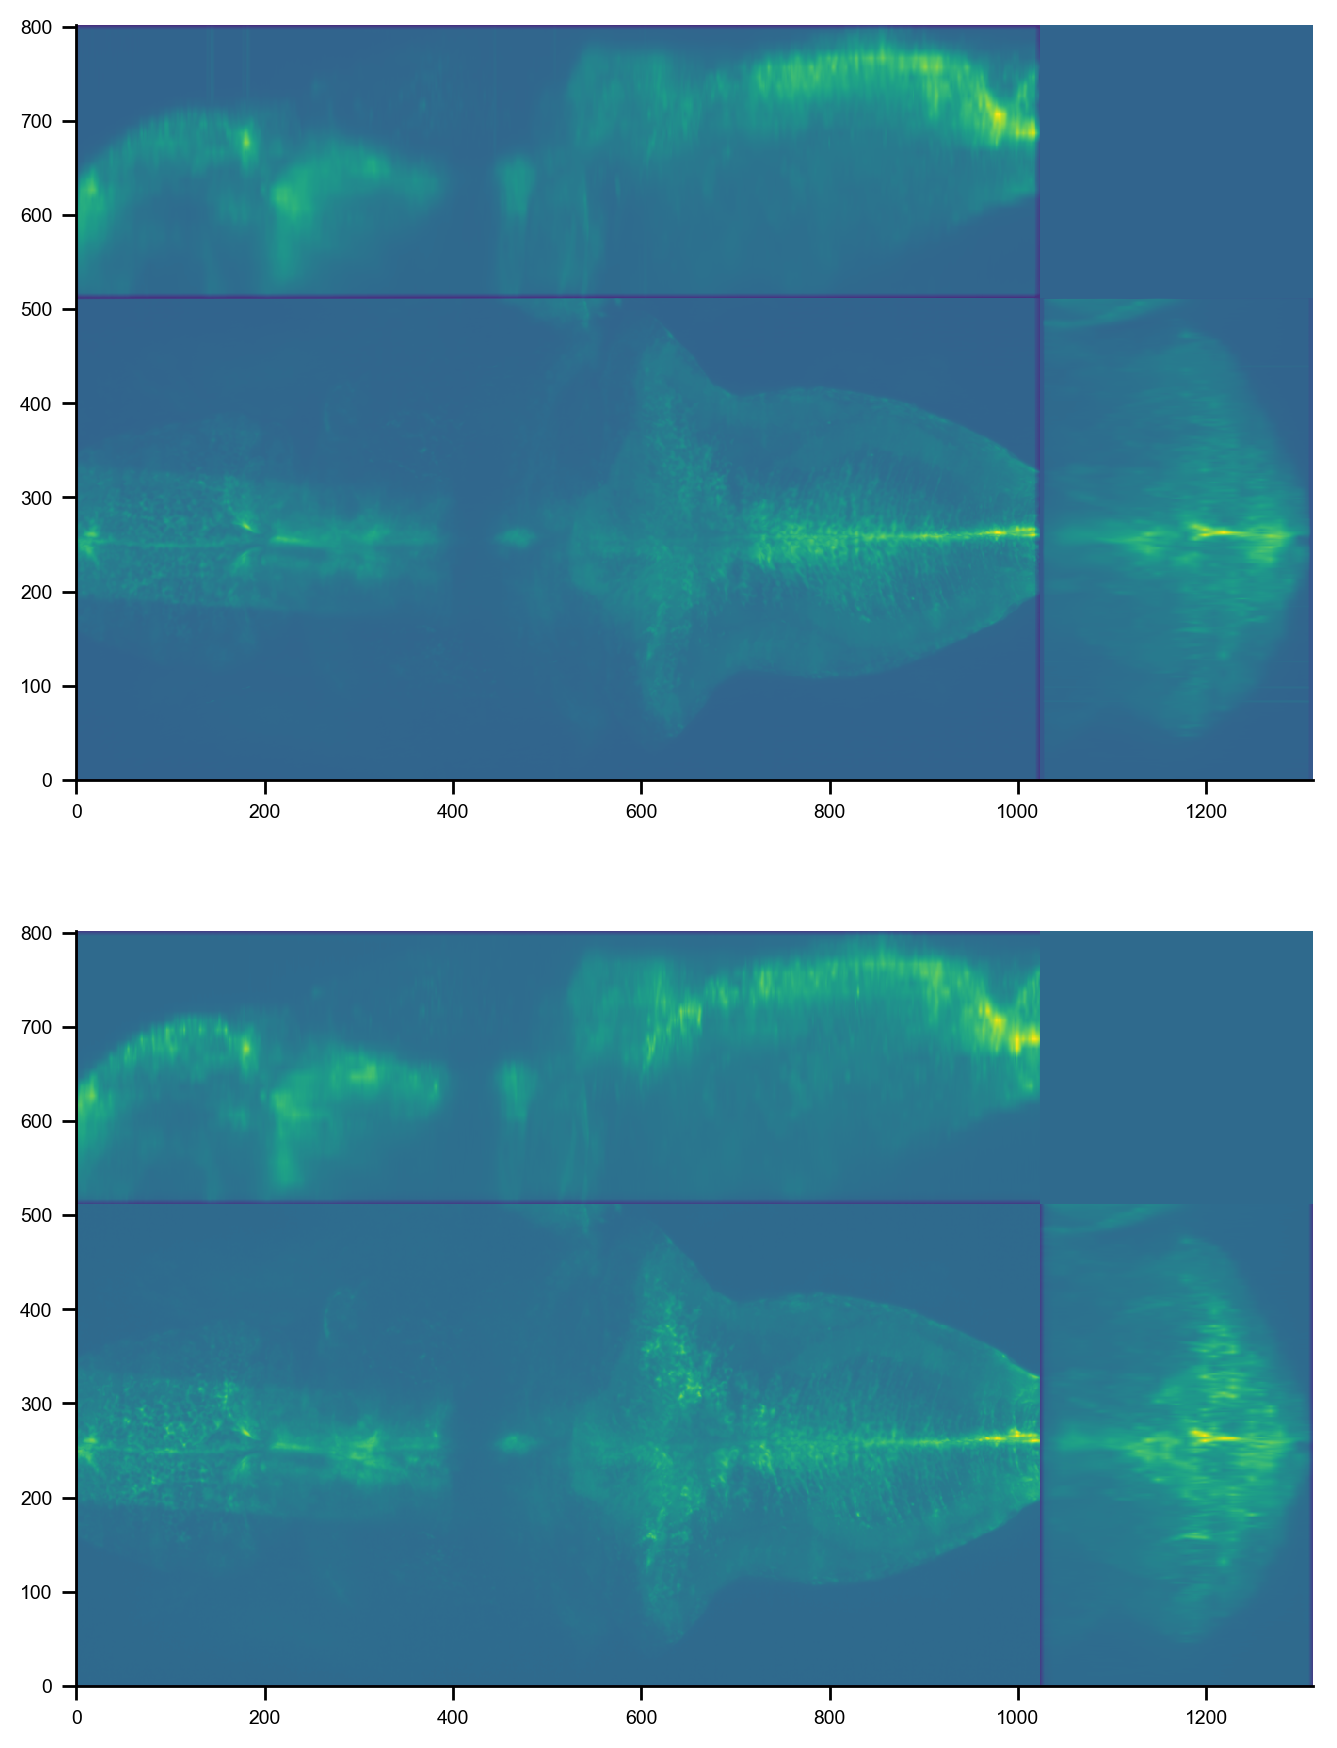

In [127]:
fig, axs = plt.subplots(nrows=2, dpi=200)
axs[0].imshow(proj_fuse(static, np.max, (10,1,1), fill_value=100), origin='lower')
axs[1].imshow(proj_fuse(translation.transform(moving), np.max, (10,1,1), fill_value=100), origin='lower')

In [10]:
mask_inds = {}
mask_inds['g'] = loadmat('/groups/ahrens/ahrenslab/mika/yu/template/glia/cmpn_indx.mat')['cmpn_indx_pval'][0]-1
mask_inds['n'] = loadmat('/groups/ahrens/ahrenslab/mika/yu/template/neur/cmpn_indx.mat')['cmpn_indx_pval'][0]-1

In [11]:
%%time

mask_fnames = {} 

mask_fnames['g'] = sorted(glob('/groups/ahrens/ahrenslab/mika/yu/data/twoc/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/ana/binary_masks0/*.nii.gz'))
mask_fnames['n'] = sorted(glob('/groups/ahrens/ahrenslab/mika/yu/data/twoc/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/ana/binary_masks1/*.nii.gz'))

shifts=  shifts_zyx
# mika's data are padded with 4 planes on the top and the bottom. this slice removes them.
shave = slice(4,-4)
def shifter(data, shifts=shifts):
    from scipy.ndimage.interpolation import shift
    return shift(data.astype('int'), shifts)

masks = {k: np.array([shifter(nib.load(m).get_data().T[shave]).astype('bool') for m in v]) for k,v in mask_fnames.items()}

CPU times: user 5min 8s, sys: 3.82 s, total: 5min 12s
Wall time: 5min 12s


In [268]:
def mask_to_rgba(mask):
    from skimage.color import gray2rgb
    from skimage.exposure import rescale_intensity
    
    msk_p = gray2rgb(rescale_intensity(my_proj(mask.astype('float'), np.max, aspect=aspect), out_range=(0,1)))
    
    msk_pa = np.zeros([msk_p.shape[0], msk_p.shape[1], msk_p.shape[2] + 1])
    msk_pa[:,:,:-1] = msk_p
    msk_pa[:,:,-1] = msk_p[:,:,0] > 0
    
    return msk_pa

In [392]:
def mask_to_rgba_canny(mask):
    from skimage.color import gray2rgb
    from skimage.exposure import rescale_intensity
    from skimage.feature import canny
    from scipy.ndimage.filters import gaussian_filter
        
    msk_p = my_proj(mask.astype('float'), np.max, aspect=aspect)
    msk_p_f = gaussian_filter(msk_p, sigma=5)
    edges = canny(msk_p_f)
    edges_smoothed = gaussian_filter(edges.astype('float'), sigma=2)
    msk_p = gray2rgb(rescale_intensity(edges_smoothed, out_range=(0,1)), alpha=1)
    msk_p[:,:,-1] = msk_p[:,:,0] > 0
    
    return msk_p

In [290]:
def rgba_jitter(): 
    return np.hstack([np.random.rand(3), 1])

In [361]:
from skimage.exposure import equalize_adapthist

In [365]:
equalize_adapthist?

(-0.5, 1023.5, -0.5, 801.5)

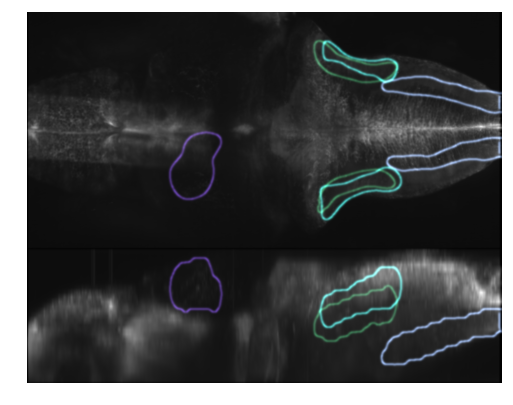

In [397]:
from skimage.color import gray2rgb
msk_ind = 1
# [15,0,7,12]
msks_pa = np.array([mask_to_rgba_canny(m) * rgba_jitter() for m in masks['n'][[15,0,7,12]]])
ref_p = gray2rgb(rescale_intensity(my_proj((static - 90).clip(0, None), np.max, aspect=aspect), out_range=(0,1)), alpha=1)
plt.imshow((msks_pa.sum(0) + ref_p).clip(0,1), origin='lower', interpolation='gaussian')
plt.axis('off')

(-0.5, 1023.5, -0.5, 801.5)

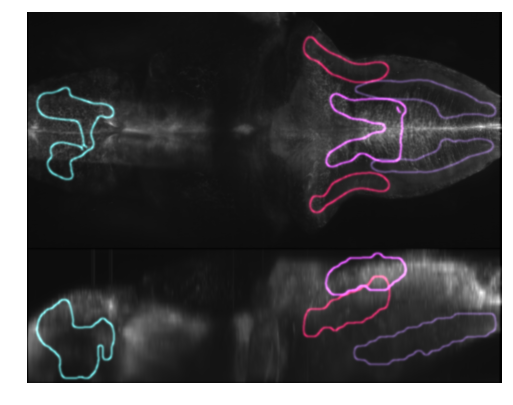

In [400]:
from skimage.color import gray2rgb
msk_ind = 1
# [9,6,8,3]
msks_pa = np.array([mask_to_rgba_canny(m) * rgba_jitter() for m in masks['g'][[9,6,8,3]]])
ref_p = gray2rgb(rescale_intensity(my_proj((static - 90).clip(0, None), np.max, aspect=aspect), out_range=(0,1)), alpha=1)
plt.imshow((msks_pa.sum(0) + ref_pa).clip(0,1), origin='lower', interpolation='gaussian')
plt.axis('off')

[None, None]

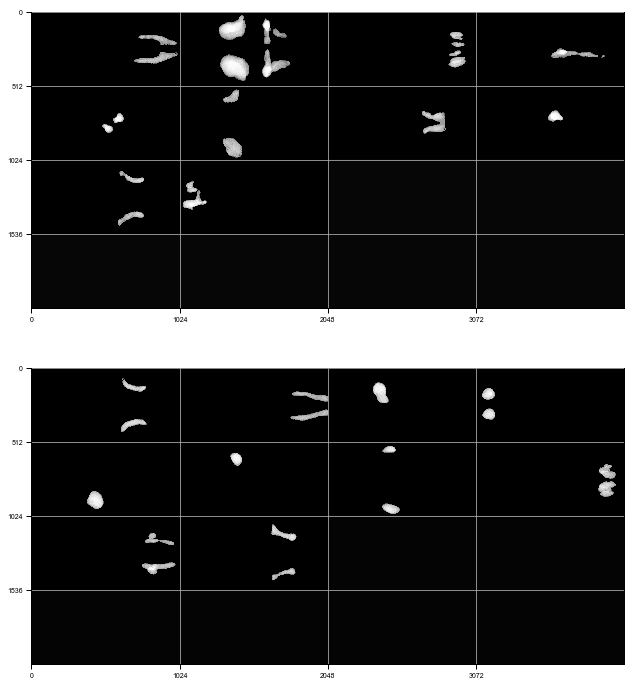

In [12]:
from skimage.util.montage import montage2d
fig, axs = plt.subplots(nrows=2, figsize=(12,12))
prj = masks['g'].std(1)[mask_inds['g']]
montage = montage2d(prj)
axs[0].imshow(montage, cmap='gray')
prj = masks['n'].std(1)[mask_inds['n']]
montage = montage2d(prj)
axs[1].imshow(montage, cmap='gray')

[ax.set_xticks(np.arange(0, montage.shape[1], prj.shape[2])) for ax in axs]
[ax.set_yticks(np.arange(0, montage.shape[0], prj.shape[1])) for ax in axs]
[ax.grid('on') for ax in axs]

In [13]:
comp_ts = {}
with h5py.File('/groups/ahrens/ahrenslab/mika/yu/data/twoc/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/ana/Binary_mask_vectors_0.mat') as fn:
    comp_ts['g'] = fn['Hm'][:]
with h5py.File('/groups/ahrens/ahrenslab/mika/yu/data/twoc/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/ana/Binary_mask_vectors_1.mat') as fn:
    comp_ts['n'] = fn['Hm'][:]

In [14]:
%%time
from multiprocessing import Pool
from functools import partial

def get_masked_data(fn, masks):
    from fish.util.fileio import read_image
    from numpy import array
    tmp = read_image(fn)
    data = dict(g=tmp[:,:tmp.shape[1]//2, :], n=tmp[:,(tmp.shape[1]//2):, :])
    masked_data = {k : array([data[k][m].mean() for m in val]) for k,val in masks.items()}
    return masked_data

parf = partial(get_masked_data, masks=masks)\
with Pool(5) as p:
    results = p.map(parf, fnames)

CPU times: user 5.82 s, sys: 10.1 s, total: 15.9 s
Wall time: 12min 55s


In [15]:
# convert single timepoints to arrays
# rescale intensities using dff_lims
from skimage.exposure import rescale_intensity
roi_ts = {k: rescale_intensity(np.array([r[k] for r in results]), in_range='uint16', out_range=tuple(dff_lims)) for k in results[-1].keys()}

In [16]:
roi_ts_norm = {k: (val - val.min(0)) / (val.ptp(0)) for k, val in roi_ts.items()}

Text(2598.91,-0.302856,'0.25 df/f')

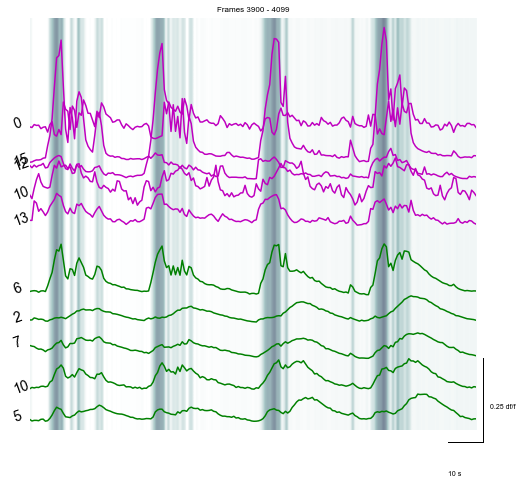

In [17]:
fs_ep = 6000
framerange = np.arange(3900,4100)
x_axis_im = cam[framerange] / fs_ep
ds_ep = 10
plr_ep = np.arange(cam[framerange[0]], cam[framerange[-1]], ds_ep)

x_axis_ep = plr_ep / fs_ep
valid_comps = {}
valid_comps['n'] = mask_inds['n'][:5]
valid_comps['g'] = mask_inds['g'][:5]

gens = ['n','g']

colors={}
colors['n'] = 'm'
colors['g'] = 'g'

fig, axs = plt.subplots(figsize=(8,8), nrows=2, sharex=True)
axs[0].title.set_text('Frames {0} - {1}'.format(framerange[0], framerange[-1]))

swimage = decimate(detrend(swims[plr_ep]), 400, ftype='fir').reshape(1,-1)
clim=(swimage.min() + .1 * swimage.ptp(), swimage.max() + swimage.ptp())

for ind, ax in enumerate(axs):
    to_plot = roi_ts[gens[ind]][framerange][:,valid_comps[gens[ind]]] - .1 * np.arange(len(valid_comps[gens[ind]]))    
    ax.plot(x_axis_im, to_plot, color=colors[gens[ind]], linewidth=1.5)
    ax.set_xlim(x_axis_im[[0,-1]])
    for z_ in range(to_plot.shape[1]):
        ax.text(x_axis_im[0]- 5, to_plot[0,z_], valid_comps[gens[ind]][z_], rotation=20, fontsize=14)
    lims = ax.get_xlim(), ax.get_ylim()
    ax.imshow(swimage, extent=(lims[0][0], lims[0][1], lims[1][0],  lims[1][1]), aspect='auto', cmap='bone_r', clim=clim, interpolation='gaussian')

axs[0].axis('off')
axs[-1].axis('off')
plt.subplots_adjust(hspace=0)

# scalebar stuff
scb_x = axs[-1].get_xlim()[-1] - 8, axs[-1].get_xlim()[-1] + 2
scb_y = axs[0].get_ylim()[0], axs[0].get_ylim()[0] + .25
axs[-1].plot([scb_x[-1], scb_x[-1]], scb_y, color='k', clip_on=False)
axs[-1].plot(scb_x, [scb_y[0], scb_y[0]], color='k', clip_on=False)
axs[-1].text(scb_x[0], scb_y[0] - .1, '{0} s'.format(int(np.diff(scb_x)[0])), clip_on=False)
axs[-1].text(scb_x[-1] + 2, scb_y[0] + .1, '{0} df/f'.format((np.diff(scb_y)[0])), clip_on=False)

#plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/{0}_mask_traces.pdf'.format(exp_name), dpi=500)

In [19]:
def my_formatter(x, pos):
    """Format 1 as 1, 0 as 0, and all values whose absolute values is between
    0 and 1 without the leading "0." (e.g., 0.7 is formatted as .7 and -0.4 is
    formatted as -.4)."""
    val_str = '{0:.2f}'.format(x)
    if np.abs(x) > 0 and np.abs(x) < 1:
        return val_str.replace("0", "", 1)
    else:
        return val_str

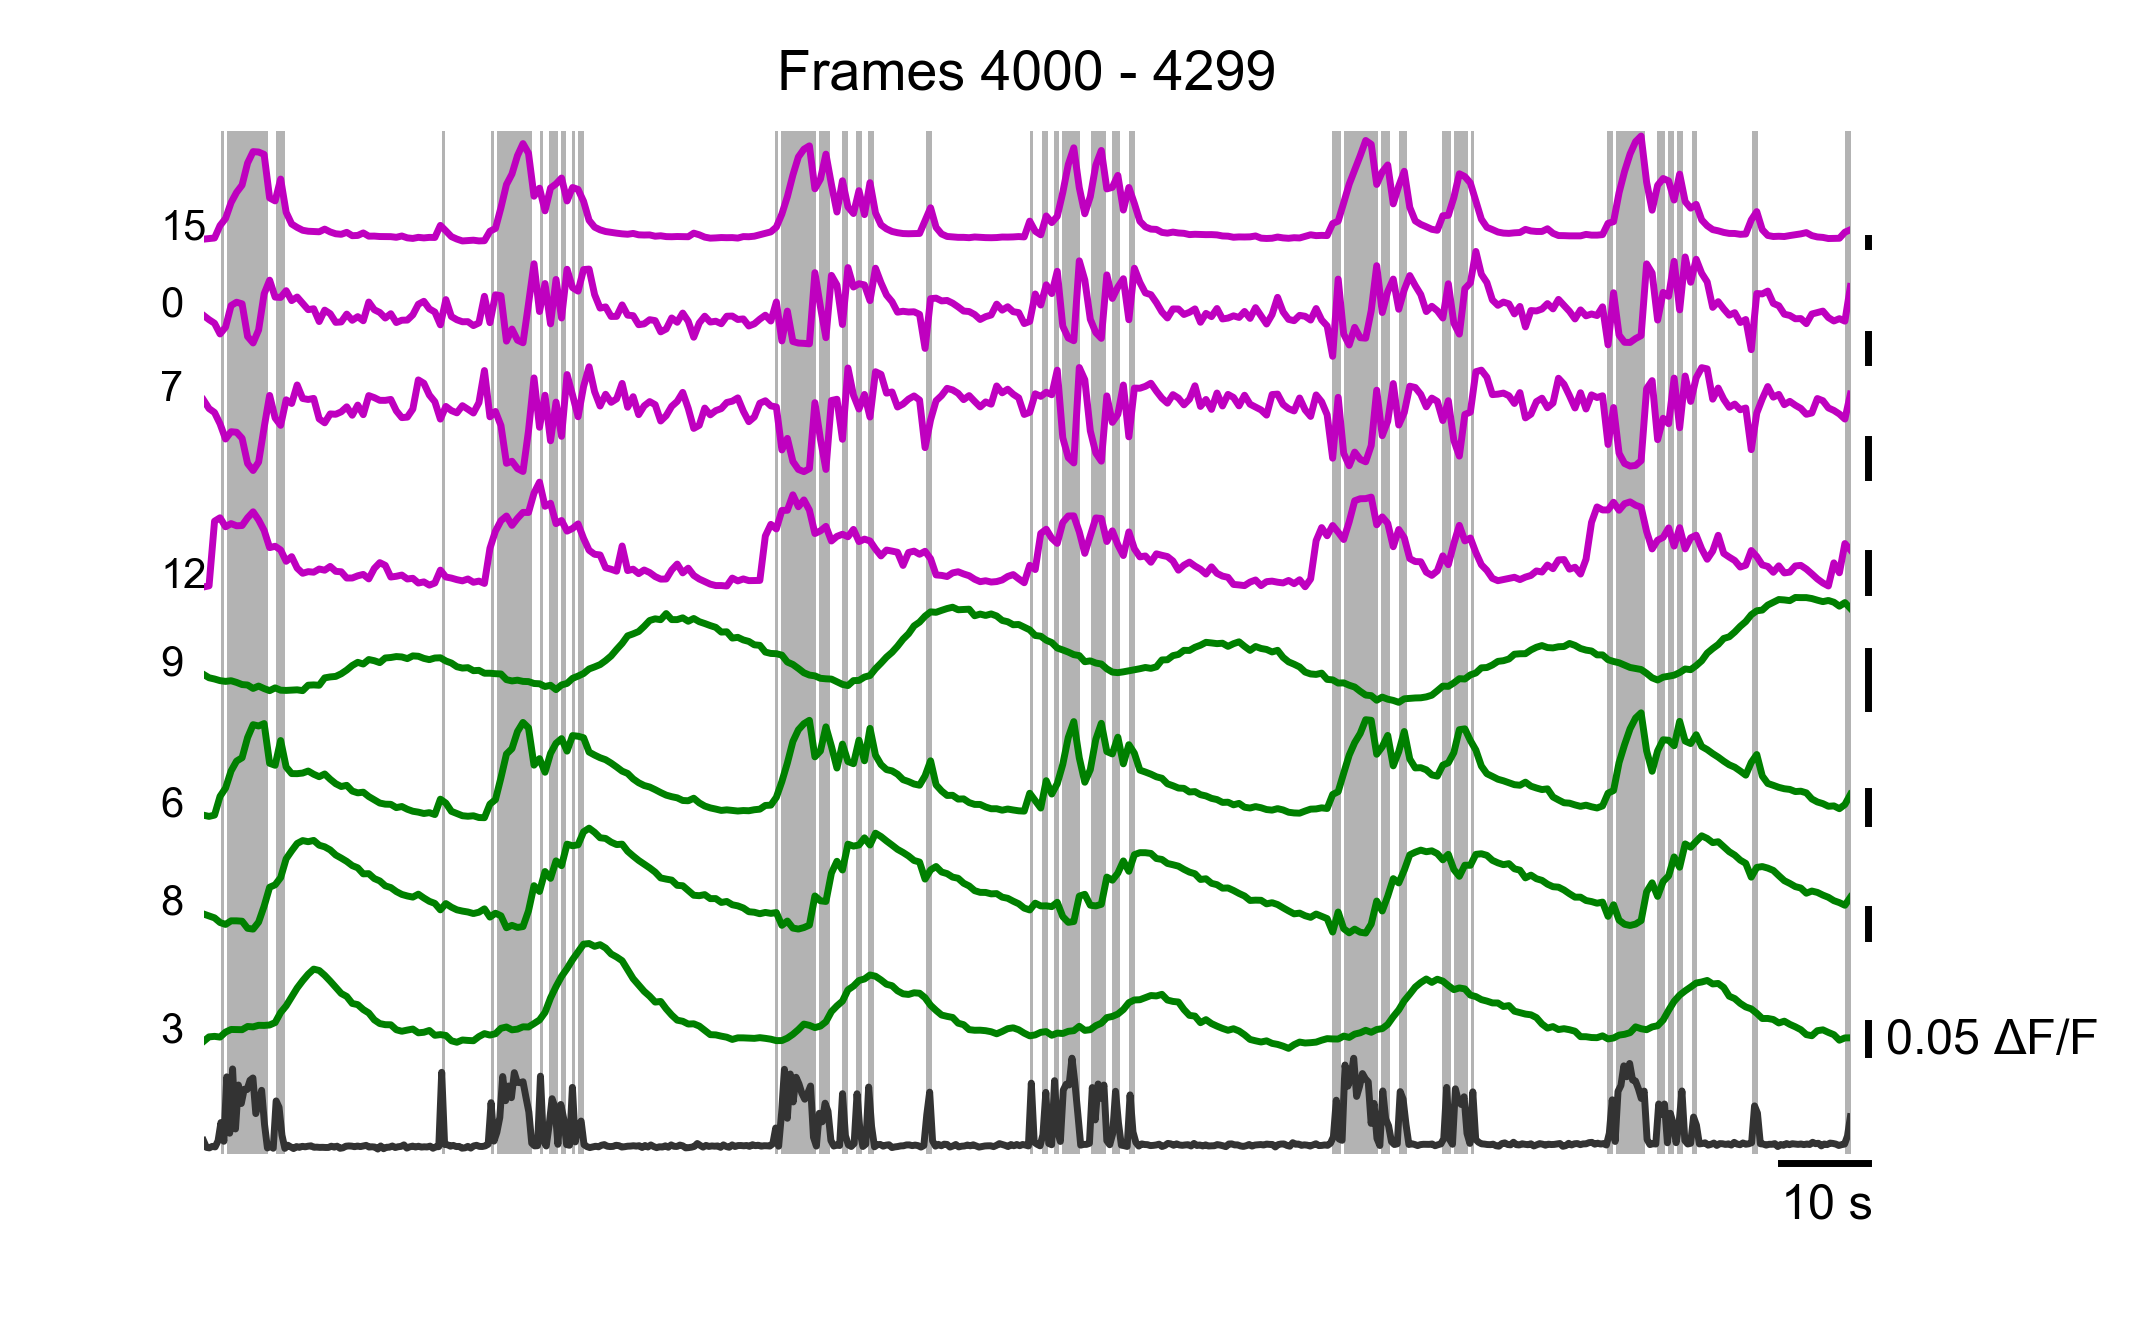

In [126]:
import matplotlib
from matplotlib.ticker import FormatStrFormatter, FuncFormatter

fs_ep = 6000
framerange = np.arange(4000,4300)
x_axis_im = cam[framerange] / fs_ep
ds_ep = 10
plr_ep = np.arange(cam[framerange[0]], cam[framerange[-1]], ds_ep)

x_axis_ep = plr_ep / fs_ep
valid_comps = {}

# indices according to misha's aesthetic judgment: 
# glia: [0,6,8,9]
# neurons: [1,0,9,2,4]

valid_comps['g'] = mask_inds['g'][[6,0,8,9]]
valid_comps['n'] = mask_inds['n'][[1,0,9,2]]

n_comps = len(valid_comps['g']) + len(valid_comps['n'])
gens = ['n','g']
dff_label = r'$\mathregular {\Delta F/F}$'
colors={}
colors['n'] = 'm'
colors['g'] = 'g'

fig, axs = plt.subplots(figsize=(8.5 / 2,11 / 4 ), nrows=1 + n_comps, sharex=True, dpi=500)
axs[0].title.set_text('Frames {0} - {1}'.format(framerange[0], framerange[-1]))

swimage = decimate(detrend(swims[plr_ep]), 200, ftype='fir', n=300).reshape(1,-1)
swm_thr = np.percentile(swimage, 75)
swimage_thr = (swimage > swm_thr).astype('float')
clim=(swimage_thr.min() + .5 * swimage_thr.ptp(), swimage_thr.max() + 1.2 * swimage_thr.ptp())

to_plot = np.hstack([roi_ts['n'][framerange, :][:,valid_comps['n']],roi_ts['g'][framerange, :][:,valid_comps['g']]])

for ind, ax in enumerate(axs[:-1]):    
    if ind < len(valid_comps['n']):
        cmp = 'n'
        ax.plot(x_axis_im, to_plot[:,ind], color=colors[cmp], linewidth=1)
        ax.text(x_axis_im[0]- 5, to_plot[0,ind], valid_comps[cmp][ind], rotation=0, fontsize=6)
    elif ind < (len(valid_comps['n']) + len(valid_comps['g'])):
        cmp = 'g'
        ax.plot(x_axis_im, to_plot[:,ind], color=colors[cmp], linewidth=1)
        ax.text(x_axis_im[0]- 5, to_plot[0,ind], valid_comps[cmp][ind - len(valid_comps[cmp])], rotation=0, fontsize=6)
    
    ax.set_xlim(x_axis_im[[0,-1]])
    
    lims = ax.get_xlim(), ax.get_ylim()
    ax.imshow(swimage_thr, extent=(lims[0][0], lims[0][1], lims[1][0],  lims[1][1]), aspect='auto', cmap='gray_r', clim=clim, interpolation='None')
    #ax.spines['bottom'].set_visible(False)
    #ax.set_yticks([to_plot[:,ind].min(), to_plot[:,ind].min() + to_plot[:,ind].ptp()/2])
    #ax.yaxis.set_major_formatter(FuncFormatter(my_formatter))
    ax.axis('off')    
    scb_x = ax.get_xlim()[-1] - 8, ax.get_xlim()[-1] + 2
    scb_y = ax.get_ylim()[0], ax.get_ylim()[0] + .05
    ax.plot([scb_x[-1], scb_x[-1]], scb_y, color='k', clip_on=False)    
    
    if ind == (len(valid_comps['n']) + len(valid_comps['g']))-1:                
        ax.text(scb_x[-1] + 2, scb_y[0], '{0:.2f} {1}'.format((np.diff(scb_y)[0]), dff_label), clip_on=False, rotation=0)

        
scb_x = ax.get_xlim()[-1] - 8, ax.get_xlim()[-1] + 2
scb_y = ax.get_ylim()[0], ax.get_ylim()[0] + .05
axs[-1].plot(np.linspace(x_axis_ep[0], x_axis_ep[-1],swimage.shape[1]), rescale_intensity(swimage.T, out_range=(0,1)), linewidth=1, color=(.2,.2,.2))
lims = axs[-1].get_xlim(), axs[-1].get_ylim()
axs[-1].axis('off')
axs[-1].imshow(swimage_thr, extent=(lims[0][0], lims[0][1], lims[1][0],  lims[1][1]), aspect='auto', cmap='gray_r', clim=clim, interpolation='None')
axs[-1].plot(scb_x, [scb_y[0] - .2, scb_y[0]- .2], color='k', clip_on=False)
axs[-1].text(scb_x[0], scb_y[0] - .8, '{0} s'.format(int(np.diff(scb_x)[0])), clip_on=False)

plt.subplots_adjust(hspace=0)
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/{0}_mask_traces.pdf'.format(exp_name))

In [ ]:
## get a chunk of data, plot an roi mean from that chunk vs the component corresponding to that ROI

In [ ]:
%%time
# load a chunk
roi_ = (slice(10, None), slice(100, 400), slice(800, None))
from skimage.io import imread
from multiprocessing import Pool
from functools import partial

def roiload(fname, roi):
    from skimage.io import imread
    return imread(fname)[roi]

parf = partial(roiload, roi=roi_)

with Pool(10) as p:
    dff = np.array(p.map(parf, fnames))

# get the mean of the chunk that overlaps with the roi
gen = 'g'
comp = 11
mask_cropped = masks[gen][comp][roi_]
roi_mean = np.array([d[mask_cropped].mean() for d in dff])

gen = 'g'
comp = 11
plr_cam = np.arange(100, 1900)
x_axis_im = cam[plr_cam]
fig, axs = plt.subplots(ncols = 2, figsize = (16,8))
axs[0].imshow(500 * masks[gen][comp].std(0).T + moving.max(0).T, cmap='gray')
axs[1].plot(x_axis_im, comp_ts[gen][plr_cam, comp])
axs[1].twinx().plot(x_axis_im, roi_mean[plr_cam], color='y')